# Knowledge Enhancement and Evaluation Project Neural Network
<b>This notebook contains the necessary steps and descriptions to train a neural network for assessing the quality of tickets.</b>

In [1]:
%matplotlib inline
import pickle
import random
from os import path

import numpy
from fastai.text import *
from matplotlib import pyplot
from pandas import DataFrame, read_excel, read_sql
from sklearn.model_selection import train_test_split

from pyodbc import connect

## Loading the Data
This cell gets all the tickets from Jira and puts them into a Pandas dataframe. This dataframe then creates a new column that combines both the description and resolution columns into a single column.

This cell will probably need to be changed to fit the data source. The neural network expects one column called Combined however this can be changed to multiple columns if necessary.

In [2]:
connection = connect('Driver={SQL Server};Server=CA-L7XNYHR2\SQLEXPRESS;Database=jiradb_UAT;Trusted_Connection=yes;')
query = '''
SELECT jiss.ID, jiss.DESCRIPTION as Description, TEXTVALUE as Resolution
FROM [jiradb_UAT].[jiraschema].[jiraissue] jiss
LEFT JOIN  [jiradb_UAT].[jiraschema].[issuetype] isstype
ON jiss.issuetype = isstype.ID 
LEFT JOIN [jiradb_UAT].[jiraschema].[customfieldvalue] CFV 
ON jiss.ID = CFV.ISSUE
WHERE CFV.CUSTOMFIELD = 10801 AND jiss.DESCRIPTION IS NOT NULL AND TEXTVALUE IS NOT NULL AND NOT isstype.pstyle IS NULL
'''
queried_dataframe = read_sql(query,connection)
queried_dataframe = queried_dataframe.fillna(' ')
queried_dataframe["Combined"] = str(queried_dataframe["Description"]) + ' ' + str(queried_dataframe["Resolution"])

<b>Optional</b> This cell applies some regular expression to the text to remove irrelevant information that occurs fairly frequently in the set. Modify this to your own dataset or skip entirely.

In [3]:
queried_dataframe["Combined"] = queried_dataframe["Combined"].replace({r'\s+$':'',r'^\s+':'',r'Incident No:(.*?)Notes:':'',r'[^A-Za-z]':' ',r'From:(.*?)Description:':'',r'Name:(.*?)Issue:':'',r'Ministry:(.*?)Issue:':''}, regex=True).replace({r'\n':' ',r'\t':' '}, regex=True)

## Training the Language Model

This cell creates the databunch used by the language model learner and creates the language model learner from the databunch. The databunch is created first by making a textlist from the text in the column that was created in the dataframe. This textlist is split randomly so that 10% is used for validation and the other 90% is used for training. The text list is then labelled to indicate this is going the be used for a language model and then transforms the text list into a databunch with a batch size as an argument.

Creating the language model takes the databunch we created above to create the dictionary and the pretrained model. The pretrained model I am using is the AWD-LSTM which stands for Average Stochastic Gradient Descent Weight Dropped Long Short Term Memory. This pretrained model is a recurrent neural network which is used as it allows it to learn from a sequence in this case sentences and documents. The final argument is the dropout multiplier which determine how much dropouts to use. This model uses embedding dropout, input dropout, weight dropout and hidden dropout.

**Relevant Information**
- [DataBunch](https://docs.fast.ai/basic_data.html#DataBunch)
- [DataBlock API](https://docs.fast.ai/data_block.html)
- [AWD-LSTM](https://arxiv.org/abs/1708.02182)

In [4]:
batchsize=30
validation_percent=0.1
dropout_lm=0.1

In [5]:
data_lm = (TextList.from_df(queried_dataframe, cols="Combined").use_partial_data(0.01).split_by_rand_pct(validation_percent).label_for_lm().databunch(bs=batchsize))
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=dropout_lm)

This cell is used to determine the proper learning rate by cross validation. This tries multiple learning rates and determines the loss from each of these.

The best learning rate is as large as possible without being so large as to cause the model to be unable to converge. The learning rate doesn't matter very much as long as it is somewhat close to optimal everything will work fine.

<img src="./images/lr1.png"/>
This image shows a standard learning rate finder curve; The best learning rate from this type of curve is near the steepest decline on the graph. I would choose around 2e-2 but as long as you are within 1e-2 and 1e-1 for this curve you wouldn't notice much of a difference.

<img src="./images/lr2.png"/>
This image is a less common learning rate finder curve; This curve is harder to interpret but still fairly simple. Look for the point before the curve starts to increase in this case around 1e-4 divide that learning rate by 10. This gives the learning rate of 1e-5.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


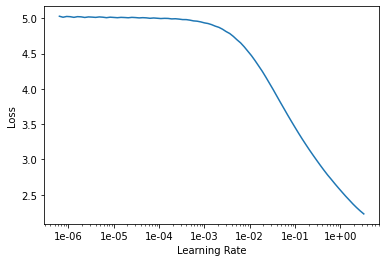

In [6]:
learn.lr_find()
learn.recorder.plot()

We train the language model using the one cycle policy on the frozen model.
```
learn.fit_one_cycle(epochs, learning rate, momentums)
```

The one cycle policy consists of adjusting momentums and learning rate as you train. Momentums are used to keep moving in the same direction as before and learning rate is the size of the step that is made. The one cycle policy starts by using high momentum and low learning rate then reducing the momentums and increasing the learning rate until you hit your max learning rate and then decreasing the learning rate and increasing the momentums.

A frozen model simply means we are holding the weights of every layer beside the last constant and training only the last layer.

The number of epochs is the amount of times the model will be trained over the whole dataset. After each batch which is defined by the batchsize in the databunch we update the model from the results. The number of epochs doesn't have much affect as if you need to train more then just run it again (Don't do it 1 epoch at a time though or you will apply the one cycle policy too much). I usually use 4-5 epochs and determine if I need more after that since the model is frozen it doesn't take many epochs to optimize the last layer.

The learning rate is simply the result of the learning rate finder.

The momentums don't need to be adjusted as they are quite conservative and adjusting them only makes it slightly faster to converge but also more likely to be unable to converge. The defaults are (0.95,0.85)

Keep training the model until the training loss is lower than the validation loss and the validation loss is increasing. This means that the model is starting to overfit so training anymore is only going to make the model worse. The accuracy at this stage does not matter as the model is trying to predict the next word in a sentence and the classifier will always have a much higher accuracy.

In [7]:
learning_rate_langmodel = 6e-2

In [8]:
learn.fit_one_cycle(4, learning_rate_langmodel, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.496082,2.212031,0.521905,00:06
1,2.976170,0.598416,0.850000,00:06
2,2.080879,0.304245,0.918571,00:06
3,1.573670,0.260951,0.933333,00:06


In [9]:
learn.unfreeze()

Now that the model is unfrozen training affects every layer. The earlier layers are not going to change as much as the last layers which is why we trained those first and since we don't want to overfit the model we are going to reduce the learning rate for the unfrozen model. I always divide the previous learning rate in half for the new learning rate.

This stage is going to take longer to train and also requires more epochs until it starts to overfit. I normally do between 5-9 epochs. If the accuracy goes down from the previous step do not worry this is normal and is why accuracy doesn't matter. Train this until training loss is lower than validation loss and validation loss is increasing

In [10]:
learn.fit_one_cycle(9, learning_rate_langmodel/2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.427956,0.648970,0.847619,00:15
1,0.448040,1.089996,0.735238,00:14
2,0.588504,1.235270,0.760952,00:14
3,0.616388,0.291715,0.929524,00:14
4,0.506867,0.254816,0.945714,00:14
5,0.424196,0.176646,0.957143,00:14
6,0.361422,0.181322,0.959048,00:14
7,0.313842,0.167741,0.960000,00:14
8,0.277131,0.166559,0.960952,00:14


Once the language model is finished training we need to export the encoder. This encoder can **not** be loaded and trained as a language model after it has been exported use the save function instead.

In [11]:
learn.save_encoder('./encoders/Language_Model_Encoder')

## Creating the Classifier

Load the labelled data into a pandas dataframe and combine them into one column like for the language model. This cell may need to be rewritten depending on how the labelled data is stored.

In [24]:
labelled_dataframe = read_excel('./data/labelled.xlsx').dropna().astype({"ID":int,"Quality":int})
labelled_dataframe["Combined"] = labelled_dataframe["DESCRIPTION"] + ' ' + labelled_dataframe["TEXTVALUE"]
labelled_dataframe.Combined = labelled_dataframe.Combined.replace({r'\s+$':'',r'^\s+':'',r'Incident No:(.*?)Notes:':'',r'[^A-Za-z]':' ',r'From:(.*?)Description:':'',r'Name:(.*?)Issue:':'',r'Ministry:(.*?)Issue:':''}, regex=True).replace({r'\n':' ',r'\t':' '}, regex=True)

**Optional** If the data is heavily imbalanced between classes then oversampling the minority class can improve the results.

This cell splits the dataframe into training data and duplicates the minority class until equal and then creates a databunch from the  new dataframe.

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(labelled_dataframe.Combined, labelled_dataframe.Quality, test_size=validation_percent)
train = DataFrame({'Combined':X_train,'Quality':Y_train})
test = DataFrame({'Combined':X_test,'Quality':Y_test})
minority_class = numpy.argmin(train.groupby("Quality").size())
majority_class = numpy.argmax(train.groupby("Quality").size())
newdf = DataFrame(numpy.repeat(train[train.Quality==minority_class].values,math.floor(train.groupby("Quality").size()[majority_class]/train.groupby("Quality").size()[minority_class])-1,axis=0))
newdf.columns = train.columns
train = train.append(newdf)
data_classifier = TextClasDataBunch.from_df('',train,test,text_cols=0,label_cols=1,bs=batchsize, vocab=data_lm.vocab)

c:\users\alec.hume\documents\keep local installation\keep training\keeptraining-env\lib\site-packages\fastai\core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


c:\users\alec.hume\documents\keep local installation\keep training\keeptraining-env\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### Important

Only run this if you are not oversampling using the above cell.

This creates the databunch for the classifier from the labelled data.

In [ ]:
data_classifier = (TextList.from_df(labelled_dataframe, vocab=data_lm.vocab, cols="Combined").split_by_rand_pct(validation_percent).label_from_df(cols="Quality").databunch(bs=batchsize))

Now that we have a trained model that can predict the next word in a sentence we want to adapt this to label tickets as low or high quality. We create a new model with the labelled data and the same architecture however without the pretrained weights then we load the weights from the model that we trained above. This new model does not contain the decoder which is used to predict the next word instead we have only the encoder which evaluates the previous words. We train this new model to classify the tickets.

Once we have created the new model we freeze the layers so only the last layer can change and find the correct learning rate the same as before.

In [26]:
dropout_class=0.3

c:\users\alec.hume\documents\keep local installation\keep training\keeptraining-env\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


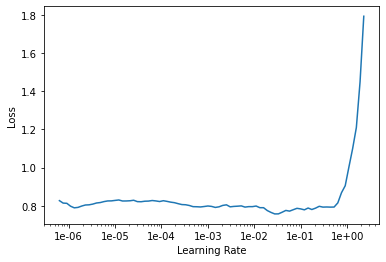

In [27]:
learn_classifier = text_classifier_learner(data_classifier, AWD_LSTM, drop_mult=dropout_class, pretrained=False, metrics=accuracy)
learn_classifier.load_encoder('./encoders/Language_Model_Encoder')
learn_classifier.freeze()
learn_classifier.lr_find()
learn_classifier.recorder.plot()

## Training The Classifier

When training the classifier we unfreeze the model gradually and slow down the learning rate as we unfreeze more layers. This method allows us to quickly adjust the last layers from predicting a word to predicting the quality without affecting the underlying knowledge learned from the language model. Once the last layer of the classifier is optimized we unfreeze the next layer and allow the model to fine tune the deeper knowledge learned previously.

The learning rate is adjusted so that when only the last layer is unfrozen that layer is trained with the given learning rate but once we start unfreezing the layers we logarthimically distribute different learning rates for each layer. This causes us to not affect the first layers as much as the last but still fine tune to the correct results. The value of ${2.6}^4$ is the best value for the starting point from empirical evidence.

In [28]:
learning_rate_classifier = 2e-3

In [29]:
learn_classifier.fit_one_cycle(3, learning_rate_classifier, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.735648,0.536973,0.820225,04:26
1,0.671513,0.652237,0.573034,04:10
2,0.631296,0.557402,0.719101,04:26


c:\users\alec.hume\documents\keep local installation\keep training\keeptraining-env\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
c:\users\alec.hume\documents\keep local installation\keep training\keeptraining-env\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndar

In [30]:
learn_classifier.freeze_to(-2)

In [31]:
learn_classifier.fit_one_cycle(4,slice(learning_rate_classifier/(2.6**4),learning_rate_classifier), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.618279,0.387628,0.831461,05:03
1,0.630932,0.453106,0.786517,05:09
2,0.600661,0.537208,0.730337,05:10
3,0.563558,0.594985,0.685393,05:37


c:\users\alec.hume\documents\keep local installation\keep training\keeptraining-env\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
c:\users\alec.hume\documents\keep local installation\keep training\keeptraining-env\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndar

In [32]:
learn_classifier.unfreeze()

In [33]:
learn_classifier.fit_one_cycle(8,slice((learning_rate_classifier/2)/(2.6**4),learning_rate_classifier/2),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.534610,0.446660,0.786517,13:35
1,0.534924,0.460531,0.764045,14:48
2,0.540055,0.371624,0.808989,13:52
3,0.490244,0.283569,0.898876,12:21
4,0.458423,0.374044,0.831461,11:52
5,0.453750,0.409887,0.842697,11:40
6,0.423769,0.346742,0.853933,13:24
7,0.415618,0.301030,0.865169,11:56


c:\users\alec.hume\documents\keep local installation\keep training\keeptraining-env\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
c:\users\alec.hume\documents\keep local installation\keep training\keeptraining-env\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndar

Once the model is finished training export the model so that it can be used for prediction.

In [34]:
learn_classifier.export("./models/KEEPModel.pkl")

In [35]:
learner = load_learner('./models', 'KEEPModel.pkl')

In [36]:
test_text_multiline = '''
SUBTASK:Initial Response on Incident.
ITSM Ticket:INC000002369276
 Received Date:2017-07-17 09:31:00.0
 RESPONSE DUE BY:2017-07-17 10:31:00.0
 RESPONDED BY:2017-07-17 12:16:00.0
 TASK NOTES:Incident No:INC000002369276

Date: 2017-07-17T12:16:00.000-0600

Type: General Information

Summary: Please add “Catherine.Eic

Notes: Please add “Catherine.Eichenlaub” in groups.nsf for the below group.

CSI BIM Editors

user added to application group and database
'''

In [37]:
learner.predict(test_text_multiline)

c:\users\alec.hume\documents\keep local installation\keep training\keeptraining-env\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
c:\users\alec.hume\documents\keep local installation\keep training\keeptraining-env\lib\site-packages\fastai\text\data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


(Category tensor(0), tensor(0), tensor([0.8247, 0.1753]))

In [38]:
test_text_singleline = 'SUBTASK:Initial Response on Incident. ITSM Ticket:INC000002369276 Received Date:2017-07-17 09:31:00.0 RESPONSE DUE BY:2017-07-17 10:31:00.0 RESPONDED BY:2017-07-17 12:16:00.0 TASK NOTES:Incident No:INC000002369276 Date: 2017-07-17T12:16:00.000-0600 Type: General Information Summary: Please add “Catherine.Eic Notes: Please add “Catherine.Eichenlaub” in groups.nsf for the below group. CSI BIM Editors user added to application group and database'

In [39]:
learner.predict(test_text_singleline)

c:\users\alec.hume\documents\keep local installation\keep training\keeptraining-env\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6580, 0.3420]))

In [40]:
import re
test_text_regex = test_text_singleline
test_text_regex = re.sub(r'\s+$', '', test_text_regex)
test_text_regex = re.sub(r'^\s+', '', test_text_regex)
test_text_regex = re.sub(r'Incident No:(.*?)Notes:', '', test_text_regex)
test_text_regex = re.sub(r'[^A-Za-z]', ' ', test_text_regex)
test_text_regex = re.sub(r'From:(.*?)Description:', '', test_text_regex)
test_text_regex = re.sub(r'Name:(.*?)Issue:', '', test_text_regex)
test_text_regex = re.sub(r'Ministry:(.*?)Issue:', '', test_text_regex)
print(test_text_regex)

SUBTASK Initial Response on Incident  ITSM Ticket INC             Received Date                       RESPONSE DUE BY                       RESPONDED BY                       TASK NOTES  Please add  Catherine Eichenlaub  in groups nsf for the below group  CSI BIM Editors user added to application group and database


In [41]:
learner.predict(test_text_regex)

c:\users\alec.hume\documents\keep local installation\keep training\keeptraining-env\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9182, 0.0818]))

In [42]:
learner.data.classes

[0, 1]

In [43]:
test_text_quality1 = 'Investigate why the $ are out of balance with RCVAging Cube but the Person # is correct I have completed the investigation for the discrepancy between the RCV Aging cube and the Special Accounts report. This discrepancy was investigated back in July 2018 (as per the attached email). Separate emails for August and Sept 2018 were not sent since the same explanation applied. Once again for October the same explanation is relevant for the difference. Going forward, no tickets will be created if the difference is due to the same explanation already reported. Let me know if you would prefer a ticket be created each month providing you with the same explanation. Explanation: The coding for the Special Accounts report does not accommodate when a person has a credit outstanding amount that has a different ‘last activity date/time’ than other transactions with outstanding amounts > 0. The Special Accounts report totals all the outstanding balances for a person based on the last activity date/time. If the total outstanding amount is greater than zero then the person and the data is reported on the Special accounts report. For the month of July, there were some total outstanding amounts with credit balances that were not included in the Special accounts report because the total outstanding amount for the ‘Last activity date/time’ was negative. Consideration to make coding changes for ‘The Special Accounts report’. Subtotal the outstanding amounts based on the last_activity_date instead of the ‘last activity date + time’. In addition, select all outstanding balance totals, not only the totals that are > 0. If these coding changes are acceptable, they could be included as part of  SR9387 to convert the ‘Special Accounts report’.'

In [44]:
learner.predict(test_text_quality1)

c:\users\alec.hume\documents\keep local installation\keep training\keeptraining-env\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5195, 0.4805]))

# What does a Neural Network do when Training?

The goal of the neural network in KEEP is to be able to classify the text given as low or high quality based on the labelled data that is given to it. A neural network learns to classify the labelled data as high or low quality but to ensure that we are actually learning what makes the text high quality we need to make sure the neural network isn't just learning the labels of our data. This is done by splitting our labelled data into a training set and a validation set so that the model only learns off the data in the training set and we can ensure the model has actually learned what we wanted with the validation set.

We can validate that the neural network is learning but to actually teach the neural network is harder. To train the model we need some method to determine how to improve the model; the solution to this is a loss function. A loss function is how we determine how incorrect a model was on its prediction, for example if a model is incorrect with 99% confidence we want to punish that much more than being incorrect with a 55% confidence. The loss function that is used for classification is called cross entropy loss and it helps tell us that the model is getting better and also how to make the model better. The loss function when minimized is the best that this model can be trained for the given data so we train the model by minimizing the loss function.

Now we know how the model learns but how does the model actually apply what it learns to itself? First we need to know what the inside of a neural network actually looks like. A neural network much like the name suggests is a network of neurons, these neurons are structured into layers with 3 different types of layers called input, output and hidden. Every neuron in the hidden layers takes the results of every neuron of the previous layer and sends its result to every neuron in the next layer. The input and output layers are different because the input layer only sends its result to every neuron in the next layer and the output layer only receives the results of every neuron in the previous layer. This is all good but what does a singular neuron actually do when it receives this information? A neuron consists of weights, a bias and an activation function. The weights and bias are adjusted during training and the activation function doesn't change ever. A neuron's weights is multiplied by the inputs of the neuron so the larger a weight the more important that neuron is on classifying the data. A neuron's bias is added after the inputs have been multiplied by the weights and the bias determines at what point the result of the neuron becomes useful. The results are then fed into the activation function before being sent to the next layer; the activation function that we use is a version of ReLu called Leaky Relu and is important as without an activation function the model could only create a linear classifier. A ReLu is very simple and either outputs the input value if greater than 0 and outputs 0 for any input less than 0. This does have a problem though called neuron death where a neuron could train to a weight and bias that always outputs 0 for any input so we solve this using a Leaky ReLu. A Leaky ReLu has the same output for positive numbers but for negative numbers instead of outputting 0 it multiples them by a very small constant which won't affect the results of the next layer much but prevents the neuron from dying.
<img src="./images/nn.jpeg"/>

We have learned what a loss function is and the structure of a neural network so now we can see how to update the weights and biases to minimize the loss function. This process is called backpropagation which consists of going through each neuron from back to front and determining how to update them. If we assume that the neuron of our output layer says that the text we feed through the model is low quality when we said it was high quality then we want to update the model to say this text is high quality so we calculate the loss and then look at the previous layer of the model. We want to decrease the values sent to the low quality output neuron so we look at the results of the previous layer and reduce the weight and/or increase the bias proportional to the result of the neuron and the loss function. We also do the same for the high quality output neuron but instead we want to increase the values sent so we increase the weight and/or decrease the bias proportional to the result of the neuron and the loss function. We do this for every neuron in the network. What we are doing during backpropagation is called gradient descent. A gradient is a multivariable generalization of a derivative so if we remember that the derivative tells us the rate of change for a point the gradient is a vector of derivatives where each value in the vector is the rate of change for each input. The gradient is a vector which means that it has a direction which is the direction of greatest increase at the point on the loss function so the negative is the greatest decrease at the point on the loss function. If we calculate the gradient for a batch of inputs and take the average then we have the direction of average greatest decrease for the loss function.

The neural network described above isn't the architecture that KEEP is using. The above describes a feed forward neural network which means all neurons connect only to the layer ahead of them but other architectures exist such as Convolutional Neural Network (CNN) which is used for images to get information from groups of inputs. The architecture that KEEP uses is called AWD-LSTM but before we can understand AWD-LSTM we need to know about recurrent neural networks or RNN. RNNs are the same as feed forward neural networks but the output of the network connects to the input of the network. This idea may seem confusing but it makes sense if we think about using a sentence as input. If we used a feed forward network then we would either have to feed each word one at a time which means we wouldn't have context from previous words or feed the whole sentence at once which wouldn't know the order of the sentence. Recurrent neural networks still have the results from their previous state so we retain information about the sentence that can't be captured with feed forward networks. In practice though RNNs can only contain so much information with one connection so holding information for a long sentence or document is unfeasible. A special type of RNNs are able to capture this information called LSTM or Long Short Term Memory which is quite a bit more complicated than just connecting to itself. An LSTM consists of 4 different neural networks.
<img src="./images/lstm.png"/>
 
The LSTM above consists of multiple parts that allows it to decide what is important in the short term connection and the long term connection. The above picture instead of showing the connection as a loop it separates it into different state for each item in the sequence which is the same as a loop just easier to look at. The top loop is the long term connection well the bottom loop is the short term connection which is the same as the output of the network. When the network receives an item it uses both the new item and the short term connection to determine what to add and remove from the long term connection. The first step is determining what needs to be removed from the long term connection which is done by the left sigma neural network called the forget gate for example if the long term connection contains information that says the person in the sentence is female so predict female pronouns and then the new item introduces a person who is male then we want to remove predicting female pronouns from the long term memory. The next part is the input gate which is the second sigma neural network and combines with the third part, the tanh neural network, called the candidate network. The input gate determines which of the candidates should be added to the long term connection and the candidate network determines which part of the short term connection and new item are important. The last part is the output network which takes the short term connection and new item and determines what to output which is then adjusted based on the information in the long term connection.

The above is quite difficult to understand however thankfully it is easy to determine when to use an LSTM and all that is necessary to know about the LSTM is the regularization methods used to prevent overfitting. LSTM as of now is the best architecture to use for any data that is in a sequence. Going back to AWD-LSTM we now know what the LSTM part is but what about the AWD part well thankfully this part is much simpler. AWD-LSTM stands for Average Stochastic Gradient Descent Weight Dropped Long Short Term Memory, you may notice the only thing left to learn about AWD-LSTM is the Average Stochastic and Weight Dropped parts. Firstly the average stochastic part contains gradient descent as doing gradient descent for every single sample in the dataset is far too slow so instead we randomly choose a sample and get the gradient for that point which is called stochastic gradient descent and then because only using 1 sample to determine how to update the model is a bad idea we take the average of multiple samples. Now we only need to learn about the weight dropped part which is how the model is regularized. RNNs and LSTMs both have a problem of overfitting on the data very quickly due to using data multiple times so to regularize the network we can use techniques like dropout.

Dropout has been massively successful in feed forward and convolutional neural networks but recurrent neural networks have a problem with dropout because they cannot hold long term connections if they are dropped. Dropout works by randomly zeroing the activations of some neurons as you are training which cause the neural network to spread its training along multiple neurons instead of making dominant connections between neurons. A better way to apply dropout for recurrent neural networks is using a random sequence to zero different things and then repeating that sequence to provide consistency that does not affect the long term connection.

Four different types of dropout are applied called embedding, input, weight and hidden. Embedding dropout zeroes some of the embedding vectors as we are training. An embedding vector is how we transform the text to usable inputs for the neural network by mapping each word to a vector and then training these vectors they should be an accurate representation of words that are related to the input word. Applying embedding dropout simply means we are ignoring some words as we are training which forces the model to learn more about how sentences are structured rather than learning which words are high quality. Input dropout is applied to the result of the embedding so while embedding dropout ignores some words input dropout ignores parts of the word. Weight dropout is simply zeroing some of the weights of a neuron which essentially removes the connection from one neuron to another. The last type of dropout that is applied is called hidden dropout which zeroes the result of a neuron which means that all connections from that neuron are removed. This use of dropout forces the neural network to be more robust but makes the neural network take longer to minimize the loss function.


The above should be enough that we can start training our neural network and adjust hyper parameters to optimize the neural network. A neural network has a parameter called learning rate which we can adjust to change how fast a network will learn. We want to reduce the amount of times we learn off the same data as eventually the neural network will learn how to classify each input rather than learning what parameters affect the classification. Choosing an optimal learning rate allows us to minimize the loss function with less data required however choosing a bad learning rate could make your model be unable to minimize the function. The learning rate affects the size of the step along the loss function; The optimal learning rate is important because too large could cause the network to bounce from one side of the minima to the other and too small could cause the network to get stuck in a local minima. You may assume that if we want a learning rate that converges fast and isn't too large then we should decrease our learning rate as we are training. This is close to what is implemented but instead we use an approach called one cycle to adjust the learning rate. One cycle adjusts the learning rate by starting with a low learning rate and increases the learning rate until it hits the maximum learning rate and then decreases the learning rate again. This seems counter intuitive to start with a low learning rate but one cycle adjusts another parameter as well called momentum. Momentum adds part of the previous step into the current step and much like the learning rate we adjust the momentum as we are training however instead of starting with low momentum we instead start with our max momentum. We decrease the momentum while learning rate is increasing and increase momentum while learning rate is decreasing. Momentum has the benefit of helping to avoid local minima however having a high momentum and high learning rate can cause the network to move too fast and step so far away from the minima that it may make it near impossible to get back and restarting is the best option.

### Learning Rate too low
<img src="./images/lowlr.gif"/>

### Good Learning Rate
<img src="./images/goodlr.gif"/>

### Learning Rate too high
<img src="./images/highlr.gif"/>

### Learning Rate far too high
<img src="./images/badlr.gif"/>

There is still lots more about neural networks to learn as this focused only on the basics and then went more specific on the design of the neural network used by KEEP. This should give you the knowledge necessary to understand what is actually happening when you are training the neural network used by KEEP. The best resource I can recommend for learning more is the fastai course at https://course.fast.ai which has two parts that teaches the basics and then the second part is rebuilding the fastai library from scratch to get a more indepth look about the whole process.
